<a href="https://colab.research.google.com/github/shaiksameer46/Volatility-Surfaces/blob/main/Stock%20Price%20simulated%20based%20on%20LocalVol%20surface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [384]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

In [385]:
# getting all maturity dates available for a particular stock option
ticker_symbol = "MSFT"
maturities = list(yf.Ticker(ticker_symbol).options)
#maturities

In [386]:
strikes = list(yf.Ticker(ticker_symbol).option_chain(maturities[6]).calls["strike"])
# len(strikes)
#strikes

In [387]:
call_prices = yf.Ticker(ticker_symbol).option_chain(maturities[0]).calls
#call_prices

In [388]:
def get_call_price(strike, maturity):
  calls = yf.Ticker(ticker_symbol).option_chain(maturity).calls
  try:
    call_value = calls[calls['strike'] == strike].lastPrice
    return call_value
  except Exception as e:
    return 0

In [389]:
def get_numerator_value(calls_df, deltaT):
  calls_diff = pd.DataFrame()
  for i in range(len(deltaT)):
    calls_diff[i] = pd.DataFrame((calls_df.iloc[:, i+2] - calls_df.iloc[:, i+1]).div(deltaT[i]))
  calls_diff = calls_diff*2
  return calls_diff

In [390]:
def get_denominator_value(calls_df):
  denominator_df = pd.DataFrame()
  for i in range(1, calls_df.shape[0] -1):
    denominator_df = denominator_df.append((((calls_df.iloc[i-1] + calls_df.iloc[i+1] - 2*calls_df.iloc[i]) /
    ((calls_df["Strike"][i] - calls_df["Strike"][i-1])**2))*calls_df["Strike"][i]**2), ignore_index=True)
  return denominator_df

In [391]:
pd.set_option('display.max_rows', None)
strikeList = []
for i in maturities[:6]:
  temp = list(yf.Ticker(ticker_symbol).option_chain(i).calls["strike"])
  strikeList.append(temp)
strike_df = pd.DataFrame(strikeList).transpose()
strike_df.columns = maturities[:6]
strikes = list(set(strike_df[strike_df.columns[0]]).intersection(*[set(strike_df[col]) for col in strike_df.columns[1:]]))
strikes.sort()
#strikes

In [392]:
#strikes = [125.0, 130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0, 165.0, 170.0, 175.0, 180.0, 185.0, 190.0, 195.0, 200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0]
maturity = maturities[:6]
call_list = []
deltaT = []
call_list.append(strikes)
for i in maturity:
  temp_list = []
  for j in strikes:
    temp_list.append(get_call_price(j, i))
  temp_list = [float(value) if(len(value) > 0) else 0  for value in temp_list]
  call_list.append(temp_list)
#call_list

In [393]:
for i in range(len(maturity[:-1])):
  deltaT.append(len(pd.date_range(pd.to_datetime(maturity[i]), pd.to_datetime(maturity[i+1]), freq='B')))
deltaT

[6, 6, 6, 6, 6]

In [394]:
# call prices df for expected strikes and maturities
calls_df = pd.DataFrame(call_list).transpose()
calls_df.columns = ['Strike'] + maturity
calls_df

,Strike,2023-12-29,2024-01-05,2024-01-12,2024-01-19,2024-01-26,2024-02-02
0,330.0,44.20,44.80,43.16,45.65,46.70,47.83
1,345.0,28.82,30.00,31.39,31.15,33.10,34.60
2,350.0,24.20,24.40,24.70,26.65,28.04,30.88
3,355.0,19.80,20.04,20.22,22.25,24.12,25.52
4,360.0,14.08,15.29,16.22,17.55,20.70,22.96
5,365.0,9.45,11.20,12.46,13.78,17.05,19.28
6,370.0,5.02,7.13,8.90,10.31,13.90,15.70
7,375.0,1.77,4.05,6.00,7.35,11.05,13.24
8,380.0,0.40,2.08,3.82,4.98,8.60,10.65
9,385.0,0.10,0.98,2.27,3.25,6.75,8.35


In [395]:
# fetching numerical value
numerator_df = get_numerator_value(calls_df, deltaT)
numerator_df.drop([0, len(numerator_df) - 1], inplace=True)
numerator_df.reset_index(drop=True, inplace=True)
#numerator_df

In [396]:
# fetching denominator value
denominator_df = get_denominator_value(calls_df)
denominator_df.drop(columns = ['Strike', maturity[5]], inplace=True)
denominator_df.columns = [0,1,2,3,4]
# denominator_df

In [397]:
# local volatility for strikes and maturities considered
vol_df = np.sqrt(numerator_df/denominator_df)
vol_df[vol_df > 1] = np.inf
vol_df.replace(np.inf, np.NaN, inplace=True)
vol_df = vol_df.apply(lambda row: row.fillna(method='ffill'))
vol_df = vol_df.apply(lambda row: row.fillna(method='bfill'))
vol_df.set_index(pd.Index(strikes[1:-1]), inplace=True)
print(vol_df.shape)
# vol_df

(18, 5)


In [398]:
x, y = np.meshgrid(vol_df.columns, vol_df.index)
z = vol_df.values

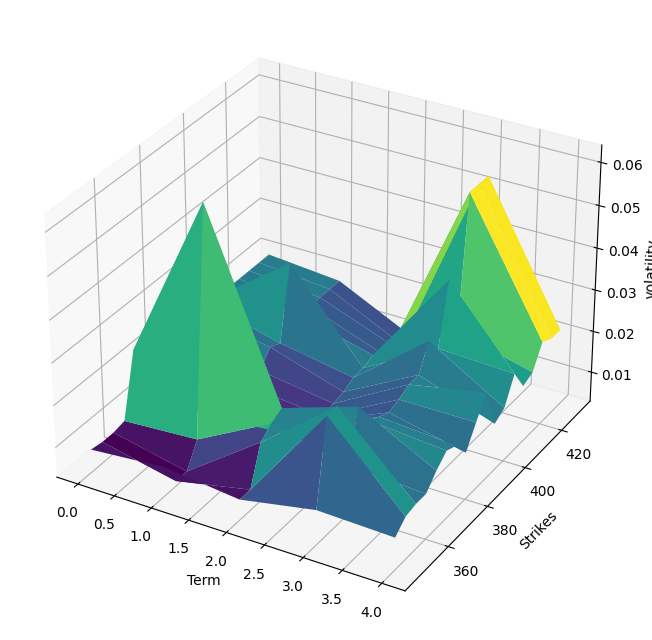

In [399]:
fig = plt.figure(figsize=(8, 11))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

# Set labels for the axes
ax.set_xlabel('Term')
ax.set_ylabel('Strikes')
ax.set_zlabel('volatility')

# Display the plot
plt.show()

In [400]:
# calculating timeframe between our first and last maturity
t = len(pd.date_range(pd.to_datetime(maturity[0]), pd.to_datetime(maturity[4]), freq='B'))
t

21

In [401]:
# expanding dataframe of vol_surface to t days instead of 5 maturities (this step helps in simulating GBM)
def expand_dataframe(vol_df):
    vol_shape = vol_df.shape[1]

    # Initialize a list to store new DataFrames
    avg_dataframes = pd.DataFrame()

    # Generate new DataFrames with average values
    for i in range(vol_shape - 1):
        avg_columns = vol_df.iloc[:, i:i+2].mean(axis=1)
        avg_df = pd.DataFrame(avg_columns)
        avg_df = np.tile(avg_df.values, (4))
        avg_df = pd.DataFrame(avg_df)
        avg_dataframes = pd.concat([avg_dataframes, avg_df], axis=1)

    avg_dataframes.columns = range(avg_dataframes.shape[1])
    return avg_dataframes

new_dataframes = expand_dataframe(vol_df)

temp_vol_df = vol_df.reset_index()
temp_vol_df = temp_vol_df.drop("index", axis=1)

expanded_vol_df = pd.concat([temp_vol_df, new_dataframes], axis=1)
expanded_vol_df.columns = range(expanded_vol_df.shape[1])
expanded_vol_df = expanded_vol_df[[0,5,6,7,8,1,9,10,11,12,2,13,14,15,16,3,17,18,19,20,4]]
expanded_vol_df.columns = range(expanded_vol_df.shape[1])
expanded_vol_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.008313,0.009035,0.009035,0.009035,0.009035,0.009757,0.008752,0.008752,0.008752,0.008752,...,0.009416,0.009416,0.009416,0.009416,0.011085,0.010803,0.010803,0.010803,0.010803,0.010520
1,0.007864,0.005960,0.005960,0.005960,0.005960,0.004057,0.005902,0.005902,0.005902,0.005902,...,0.019249,0.019249,0.019249,0.019249,0.030750,0.021884,0.021884,0.021884,0.021884,0.013018
2,0.007864,0.005960,0.005960,0.005960,0.005960,0.004057,0.010390,0.010390,0.010390,0.010390,...,0.023737,0.023737,0.023737,0.023737,0.030750,0.022179,0.022179,0.022179,0.022179,0.013607
3,0.008449,0.008984,0.008984,0.008984,0.008984,0.009519,0.014198,0.014198,0.014198,0.014198,...,0.016817,0.016817,0.016817,0.016817,0.014758,0.014182,0.014182,0.014182,0.014182,0.013607
4,0.023395,0.043085,0.043085,0.043085,0.043085,0.062775,0.041547,0.041547,0.041547,0.041547,...,0.023215,0.023215,0.023215,0.023215,0.026111,0.021407,0.021407,0.021407,0.021407,0.016703
5,0.010433,0.010433,0.010433,0.010433,0.010433,0.010432,0.010918,0.010918,0.010918,0.010918,...,0.016052,0.016052,0.016052,0.016052,0.020700,0.019905,0.019905,0.019905,0.019905,0.019111
6,0.008477,0.009340,0.009340,0.009340,0.009340,0.010203,0.010372,0.010372,0.010372,0.010372,...,0.014909,0.014909,0.014909,0.014909,0.019278,0.018645,0.018645,0.018645,0.018645,0.018012
7,0.009519,0.010131,0.010131,0.010131,0.010131,0.010743,0.010526,0.010526,0.010526,0.010526,...,0.014188,0.014188,0.014188,0.014188,0.018067,0.016055,0.016055,0.016055,0.016055,0.014042
8,0.014358,0.012770,0.012770,0.012770,0.012770,0.011182,0.010305,0.010305,0.010305,0.010305,...,0.014171,0.014171,0.014171,0.014171,0.018915,0.018942,0.018942,0.018942,0.018942,0.018969
9,0.027695,0.020295,0.020295,0.020295,0.020295,0.012894,0.011577,0.011577,0.011577,0.011577,...,0.015273,0.015273,0.015273,0.015273,0.020287,0.022029,0.022029,0.022029,0.022029,0.023770


In [402]:
# finding mu, s0 using log returns of a ticker from yahoo finance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import datetime

stock = yf.Ticker(ticker_symbol)
market_data = stock.history(start="2023-01-01", end=datetime.datetime.now().strftime("%Y-%m-%d"), auto_adjust=False)
stock_adj = market_data['Adj Close']
s0 = stock_adj[-1]
log_returns = np.log(stock_adj/stock_adj.shift(1)).dropna()
log_return_0 = log_returns[0]
mu = log_returns.mean()
#mu = 0.05
daily_vol = log_returns.std()
print(mu, s0)

0.001853493514318724 374.6600036621094


In [403]:
#GBM Using Local Vol Surface, projecting volatilities selected based on previous day stock value
N= 50
T = 1
dt = T/t

sim_prices = np.zeros((N, t))
sim_prices[:, 0] = s0
sigma = np.zeros((N, t))
sigma[:, 0] = 0

for i in range(1, t):
  rand = np.random.normal(0, 1, N)
  vol_index = np.zeros((N,1))
  prev_sim_price = np.array(sim_prices[:, i-1]).reshape(-1, 1)

  for j in range(len(expanded_vol_df)):
    closest_index = np.argmin(np.abs(calls_df['Strike'].values - prev_sim_price[j,0]))
    vol_index[j, 0] = closest_index

  sigma[:,i] = expanded_vol_df[i-1].iloc[vol_index.flatten()].values
  sim_prices[:, i] = sim_prices[:, i-1] * np.exp((mu - sigma[:,i]**2 / 2) * dt + sigma[:,i] * np.sqrt(dt) * rand)

stock_df = pd.DataFrame(sim_prices)
sigma_df = pd.DataFrame(sigma)
print(np.mean(stock_df[t-1]))
stock_df = stock_df.T
stock_df.index = pd.bdate_range(start=datetime.datetime.now(), periods=t)
sigma_df

375.36656735341415


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,0.009519,0.010131,0.010131,0.010131,0.010131,0.010743,0.010526,0.010526,0.010526,...,0.010308,0.014188,0.014188,0.014171,0.014171,0.018915,0.018942,0.018942,0.018942,0.018942
1,0.0,0.009519,0.010131,0.010131,0.010131,0.010131,0.010743,0.010305,0.010305,0.010526,...,0.010308,0.014188,0.014188,0.014188,0.014188,0.018067,0.016055,0.018942,0.018942,0.018942
2,0.0,0.009519,0.010131,0.010131,0.010131,0.010131,0.010743,0.010526,0.010526,0.010526,...,0.010308,0.014188,0.014188,0.014188,0.014188,0.018067,0.016055,0.016055,0.016055,0.016055
3,0.0,0.009519,0.010131,0.010131,0.010131,0.010131,0.010743,0.010526,0.010526,0.010526,...,0.010308,0.014188,0.014188,0.014188,0.014188,0.018067,0.016055,0.016055,0.018645,0.018645
4,0.0,0.009519,0.010131,0.009340,0.010131,0.010131,0.010743,0.010526,0.010526,0.010526,...,0.009427,0.014171,0.014171,0.014171,0.014171,0.018915,0.018942,0.022029,0.018942,0.018942
5,0.0,0.009519,0.010131,0.010131,0.010131,0.010131,0.010743,0.010526,0.010526,0.010526,...,0.010308,0.014188,0.014188,0.014188,0.014188,0.018067,0.018942,0.018942,0.018942,0.018942
6,0.0,0.009519,0.010131,0.010131,0.010131,0.010131,0.010743,0.010526,0.010526,0.010526,...,0.010308,0.014188,0.014188,0.014188,0.014188,0.018915,0.018942,0.018942,0.018942,0.018942
7,0.0,0.009519,0.010131,0.010131,0.010131,0.012770,0.011182,0.010305,0.010305,0.010305,...,0.010308,0.014188,0.014171,0.014171,0.014188,0.018067,0.016055,0.016055,0.018942,0.018942
8,0.0,0.009519,0.010131,0.010131,0.010131,0.010131,0.010743,0.010526,0.010526,0.010526,...,0.010308,0.014188,0.014188,0.014909,0.014909,0.019278,0.018645,0.018645,0.018645,0.018645
9,0.0,0.009519,0.010131,0.010131,0.010131,0.010131,0.011182,0.010526,0.010526,0.010526,...,0.010308,0.014188,0.014188,0.014188,0.014188,0.018067,0.016055,0.018942,0.018942,0.016055


In [404]:
# GBM Stock values calculated based on local volatility
stock_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2023-12-27,374.660004,374.660004,374.660004,374.660004,374.660004,374.660004,374.660004,374.660004,374.660004,374.660004,...,374.660004,374.660004,374.660004,374.660004,374.660004,374.660004,374.660004,374.660004,374.660004,374.660004
2023-12-28,375.437317,375.845660,374.509513,374.381608,373.205598,376.284727,374.973313,375.277863,375.125045,374.730820,...,375.978510,373.382310,375.474075,374.730784,373.952666,375.053801,374.612168,374.228829,373.754654,373.697687
2023-12-29,374.962769,375.556469,373.540620,374.445591,372.357290,376.616830,376.027774,375.550251,375.079420,374.320066,...,375.921557,373.393195,375.183244,374.734463,374.182978,377.151094,374.851130,375.120060,373.924311,372.238763
2024-01-01,374.525119,375.820366,374.170620,374.651814,373.088597,375.435388,376.100614,376.686759,374.306764,375.280762,...,376.191372,373.980238,376.338990,375.807062,373.702548,375.944059,374.416698,375.875653,373.669384,372.253045
2024-01-02,374.096177,377.168795,373.364422,374.739277,374.035917,376.999365,375.555569,377.520145,373.815997,376.457398,...,376.717121,374.460021,376.031080,377.419425,372.339883,376.903843,374.234175,375.204367,375.474418,372.826304
2024-01-03,373.881518,376.935435,373.623893,374.388875,375.144326,377.104816,376.433685,377.770824,374.567692,377.611299,...,376.618295,375.249592,376.623506,377.498027,372.329057,376.019271,374.629078,374.244221,373.980983,373.600307
2024-01-04,374.252878,377.745949,373.011220,374.830486,374.790418,376.847841,377.326279,377.664975,373.988650,376.387255,...,376.657119,374.874318,376.193811,377.817071,371.818907,375.168543,374.254273,373.222401,375.489784,374.107317
2024-01-05,375.680965,378.190932,374.351798,375.179113,375.448229,375.037547,376.566914,377.728719,374.073243,376.353450,...,377.973280,374.440575,376.535247,377.863448,372.091400,374.388951,373.285397,373.225994,374.918463,374.810678
2024-01-08,374.420304,377.019117,374.025724,373.888018,376.928629,374.912109,376.078085,378.158825,374.865528,376.564641,...,379.971277,373.363882,377.588414,377.868772,371.549334,374.685322,372.390275,372.373456,373.710335,375.234237
2024-01-09,374.733729,376.346757,375.369093,373.351078,378.073418,375.049365,375.526430,378.093478,373.819569,376.784409,...,381.297734,374.010568,378.178831,376.595028,371.048285,373.576492,371.875841,372.971435,373.462336,376.036111


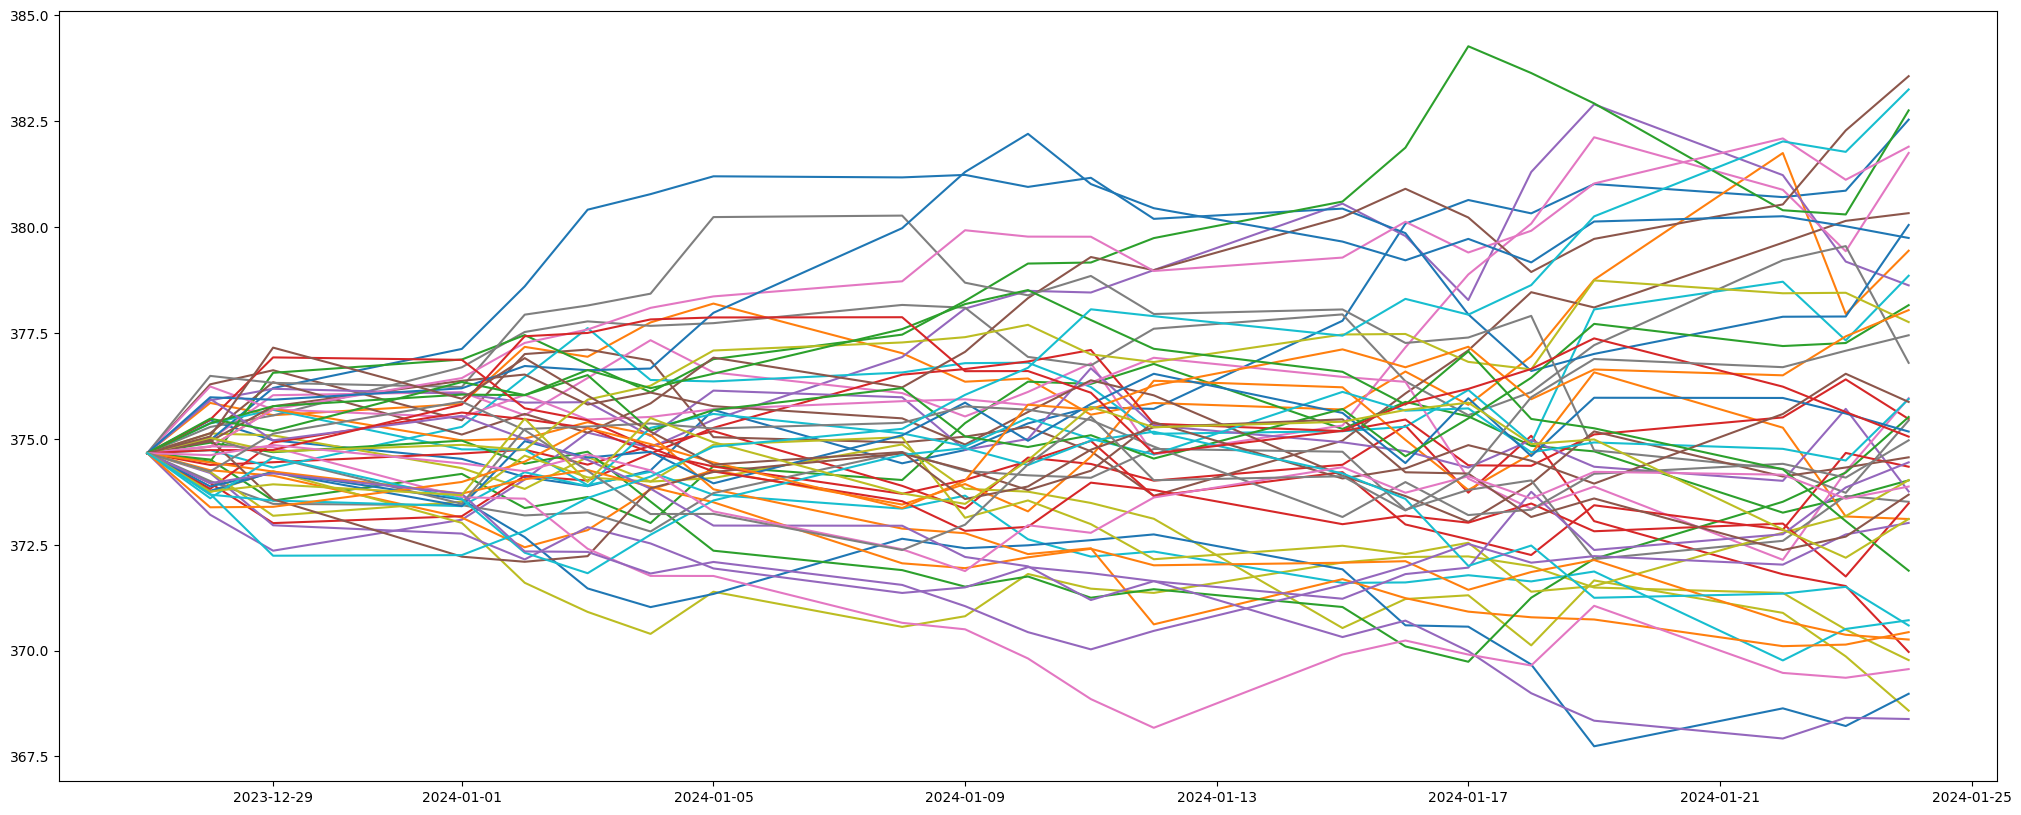

In [405]:
plt.figure(figsize=(25,10))
plt.plot(stock_df.iloc[:,:])
plt.show()